In [2]:
from typing import TypedDict, Annotated, Any
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from rich.markdown import Markdown

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [3]:
load_dotenv()
console = Console()
memory = MemorySaver()

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    """return the current stock price give stock symbol
    :param symbol (str): Stock ticker symbol, e.g. 'MSFT' for Microsoft.
    :return: Current stock price as a float.
    """
    # dummy code, replace with actual implementation
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6,
    }.get(symbol, 0.0)


tools = [get_stock_price]

In [5]:
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.0)
# bind llm with tools
llm_with_tools = llm.bind_tools(tools)

c:\Users\BHOBEMRMANISHJAGDISH\Dev\code\git_projects\learning_langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
# build our graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))
# build edges: START -> chatbot -> END
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
# loop back to chatbot from tools node
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)

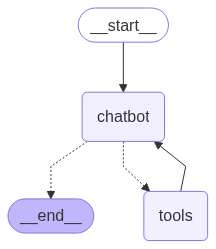

In [8]:
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langsmith import traceable


@traceable
def run_chatbot(prompt: str, config=None) -> dict[str, Any] | Any:
    message = {"role": "user", "content": prompt}
    if config is not None:
        response = graph.invoke({"messages": [message]}, config=config)
    else:
        response = graph.invoke({"messages": [message]})

    return response

In [10]:
# set config for memory
config = {"configurable": {"thread_id": "abc@123"}}

In [11]:
# here we expect the graph to run via the tools path
# (inspecty response variable in your IDE - it should show too call(s))
prompt: str = "What is the latest price for AMZN stock? Return just the price."
message = {"role": "user", "content": prompt}
# response = graph.invoke({"messages": [message]}, config=config)
# console.print(run_chatbot(prompt), style="cyan")
response = run_chatbot(prompt, config)
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
# deliberate call to prevent rate limit errors
sleep(1)

150

[
    HumanMessage(
        content='What is the latest price for AMZN stock? Return just the price.',
        additional_kwargs={},
        response_metadata={},
        id='9cb04019-29c0-4ab3-b081-2a5a9b35b1fa'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d6f64a3c-08d1-444a-af03-0322027c4516-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AMZN'},
                'id': '42ad8d22-af5b-49af-a913-fff2e442cc38',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 93,
            'output_tokens': 18,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='150.0',
        name='get_stock_price',
        id='216e94a5-b837-4b8e-b960-523df56dc2dc',
        tool_call_id='42ad8d22-af5b-49af-a913-fff2e442cc38'
    ),
    AIMessage(
        content='150',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d90a99f1-a90b-4ae5-a1a4-276d0c2f8779-0',
        usage_metadata={
            'input_tokens': 130,
            'output_tokens': 3,
            'total_tokens': 133,
            'input_token_details': {'cache_read': 0}
        }
    )
]

In [12]:
# here we DON'T expect the graph to run via the tools path
# (inspecty response variable in your IDE - it should NOT show a tool call)
prompt: str = "Who discovered penicillin? Return just a name."
message = {"role": "user", "content": prompt}
# response = graph.invoke({"messages": [message]}, config=config)
# console.print(run_chatbot(prompt), style="green")
response = run_chatbot(prompt, config)
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
sleep(1)

Alexander Fleming

[
    HumanMessage(
        content='What is the latest price for AMZN stock? Return just the price.',
        additional_kwargs={},
        response_metadata={},
        id='9cb04019-29c0-4ab3-b081-2a5a9b35b1fa'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d6f64a3c-08d1-444a-af03-0322027c4516-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AMZN'},
                'id': '42ad8d22-af5b-49af-a913-fff2e442cc38',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 93,
            'output_tokens': 18,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='150.0',
        name='get_stock_price',
        id='216e94a5-b837-4b8e-b960-523df56dc2dc',
        tool_call_id='42ad8d22-af5b-49af-a913-fff2e442cc38'
    ),
    AIMessage(
        content='150',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d90a99f1-a90b-4ae5-a1a4-276d0c2f8779-0',
        usage_metadata={
            'input_tokens': 130,
            'output_tokens': 3,
            'total_tokens': 133,
            'input_token_details': {'cache_read': 0}
        }
    ),
    HumanMessage(
        content='Who discovered penicillin? Return just a name.',
        additional_kwargs={},
        response_metadata={},
        id='92220f07-2adb-4f10-a58c-b008381ba514'
    ),
    AIMessage(
        content='Alexander Fleming',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--58301542-96cb-41c2-8b02-dc13fed89fe1-0',
        usage_metadata={
            'input_tokens': 144,
            'output_tokens': 2,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    )
]

In [13]:
# what if I ask a combined question like this, will the graph work?
prompt: str = (
    "If I buy 10 shares of MSFT and 12 of AAPL, what is the total value of my portfolio? Show me your reasoning"
)
message = {"role": "user", "content": prompt}
# response = graph.invoke({"messages": [message]}, config=config)
# console.print(Markdown(run_chatbot(prompt)), style="yellow")
response = run_chatbot(prompt, config)
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
sleep(1)

Here's the reasoning for the total value of your portfolio:

*   **MSFT:** 10 shares * $200.30/share = $2003.00
*   **AAPL:** 12 shares * $100.40/share = $1204.80

**Total Portfolio Value:** $2003.00 + $1204.80 = $3207.80

[
    HumanMessage(
        content='What is the latest price for AMZN stock? Return just the price.',
        additional_kwargs={},
        response_metadata={},
        id='9cb04019-29c0-4ab3-b081-2a5a9b35b1fa'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d6f64a3c-08d1-444a-af03-0322027c4516-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AMZN'},
                'id': '42ad8d22-af5b-49af-a913-fff2e442cc38',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 93,
            'output_tokens': 18,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='150.0',
        name='get_stock_price',
        id='216e94a5-b837-4b8e-b960-523df56dc2dc',
        tool_call_id='42ad8d22-af5b-49af-a913-fff2e442cc38'
    ),
    AIMessage(
        content='150',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d90a99f1-a90b-4ae5-a1a4-276d0c2f8779-0',
        usage_metadata={
            'input_tokens': 130,
            'output_tokens': 3,
            'total_tokens': 133,
            'input_token_details': {'cache_read': 0}
        }
    ),
    HumanMessage(
        content='Who discovered penicillin? Return just a name.',
        additional_kwargs={},
        response_metadata={},
        id='92220f07-2adb-4f10-a58c-b008381ba514'
    ),
    AIMessage(
        content='Alexander Fleming',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--58301542-96cb-41c2-8b02-dc13fed89fe1-0',
        usage_metadata={
            'input_tokens': 144,
            'output_tokens': 2,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    HumanMessage(
        content='If I buy 10 shares of MSFT and 12 of AAPL, what is the total value of my portfolio? Show me your 
reasoning',
        additional_kwargs={},
        response_metadata={},
        id='5bf89397-13cb-4010-80cb-ed1cfb023b0a'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--6f4515e3-ebbb-4842-a4a7-00ca74b2d6a5-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'MSFT'},
                'id': '9c2ab4cc-34a0-4a98-b4fe-c90497b60163',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 179,
            'output_tokens': 18,
            'total_tokens': 330,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='200.3',
        name='get_stock_price',
        id='78a54ebb-da3c-47ff-b055-ebb4c4be3fa1',
        tool_call_id='9c2ab4cc-34a0-4a98-b4fe-c90497b60163'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AAPL"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_re

Notice that the LLM is now able to reason & calculate the total investment due to the loopback from the tools to the LLM.

However, the LLM won't be able to handle a query like the following, which refers to the _output_ from the previous queries. To enable that, we'll need to provide LLM with memory, which is what we'll do in the next notebook.

In [14]:
# this question will not work!
prompt: str = (
    "With my total portfolio value, how many shares of RIL can I buy? Show me your reasoning"
)
message = {"role": "user", "content": prompt}
# response = graph.invoke({"messages": [message]}, config=config)
# console.print(Markdown(run_chatbot(prompt)), style="cyan")
response = run_chatbot(prompt, config)
console.print(response["messages"][-1].content, style="cyan")
console.print(response["messages"])
sleep(1)

Here's the reasoning for how many shares of RIL you can buy:

*   **Total Portfolio Value:** $3207.80 (from previous calculation)
*   **RIL Share Price:** $87.60

**Number of RIL Shares:** $3207.80 / $87.60 per share = 36.61872146118721 shares

You can buy approximately 36 shares of RIL.

[
    HumanMessage(
        content='What is the latest price for AMZN stock? Return just the price.',
        additional_kwargs={},
        response_metadata={},
        id='9cb04019-29c0-4ab3-b081-2a5a9b35b1fa'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AMZN"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d6f64a3c-08d1-444a-af03-0322027c4516-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'AMZN'},
                'id': '42ad8d22-af5b-49af-a913-fff2e442cc38',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 93,
            'output_tokens': 18,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='150.0',
        name='get_stock_price',
        id='216e94a5-b837-4b8e-b960-523df56dc2dc',
        tool_call_id='42ad8d22-af5b-49af-a913-fff2e442cc38'
    ),
    AIMessage(
        content='150',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--d90a99f1-a90b-4ae5-a1a4-276d0c2f8779-0',
        usage_metadata={
            'input_tokens': 130,
            'output_tokens': 3,
            'total_tokens': 133,
            'input_token_details': {'cache_read': 0}
        }
    ),
    HumanMessage(
        content='Who discovered penicillin? Return just a name.',
        additional_kwargs={},
        response_metadata={},
        id='92220f07-2adb-4f10-a58c-b008381ba514'
    ),
    AIMessage(
        content='Alexander Fleming',
        additional_kwargs={},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--58301542-96cb-41c2-8b02-dc13fed89fe1-0',
        usage_metadata={
            'input_tokens': 144,
            'output_tokens': 2,
            'total_tokens': 191,
            'input_token_details': {'cache_read': 0}
        }
    ),
    HumanMessage(
        content='If I buy 10 shares of MSFT and 12 of AAPL, what is the total value of my portfolio? Show me your 
reasoning',
        additional_kwargs={},
        response_metadata={},
        id='5bf89397-13cb-4010-80cb-ed1cfb023b0a'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_reason': 'STOP',
            'safety_ratings': []
        },
        id='run--6f4515e3-ebbb-4842-a4a7-00ca74b2d6a5-0',
        tool_calls=[
            {
                'name': 'get_stock_price',
                'args': {'symbol': 'MSFT'},
                'id': '9c2ab4cc-34a0-4a98-b4fe-c90497b60163',
                'type': 'tool_call'
            }
        ],
        usage_metadata={
            'input_tokens': 179,
            'output_tokens': 18,
            'total_tokens': 330,
            'input_token_details': {'cache_read': 0}
        }
    ),
    ToolMessage(
        content='200.3',
        name='get_stock_price',
        id='78a54ebb-da3c-47ff-b055-ebb4c4be3fa1',
        tool_call_id='9c2ab4cc-34a0-4a98-b4fe-c90497b60163'
    ),
    AIMessage(
        content='',
        additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AAPL"}'}},
        response_metadata={
            'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
            'finish_re